In [ ]:
# You will need to run this block twice to make it effective
!apt-get update 
!apt-get install cmake 
!pip install --upgrade setuptools 
!pip install ez_setup 
!pip install gym==0.24.1
!pip install gym[all]

!pip install gym pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg 

In [ ]:
import utils
from importlib import reload
reload(utils)
from utils import*

from torch._C import dtype
import gym
from gym.wrappers.monitoring import video_recorder
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.distributions.beta import Beta
import numpy as np
import copy
from collections import deque
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

from torch import randint
from time import sleep
import pickle
import statistics as st
from gym.core import RewardWrapper
import gc

import os           

In [ ]:
reward_hist = []
ep_len_hist = []
lr_hist = []
best_score = 0

In [ ]:
def train(batch_size=50,N=50,lr=0.001,n_epochs=4,gamma=0.92,gae_lambda=0.95,policy_clip=0.1,n_games=100,action_space = "steer",steer_model=None,thrust_model=None,steer_policy="stochastic",thrust_policy="stochastic"):
    global best_score
    env = wrap_env(gym.make("CarRacing-v1").unwrapped)
    agent = Agent(batch_size=batch_size,lr=lr,n_epochs=n_epochs,gamma=gamma,gae_lambda=gae_lambda,policy_clip=policy_clip,
                  action_space=action_space,steer_policy=steer_policy,thrust_policy=thrust_policy)
    agent.load_models(steer_name=steer_model,thrust_name=thrust_model)

    n_steps = 0
    avg_score = 0
    high_learn = 0
    for i in range(n_games):
        observation = env.reset()
        done = False

        #skip first few useless episodes
        state, reward, done, info = env.skip_episodes(70,[0,0.5,0])

        while not done:
            n_steps+=1
            steer_action, thrust_action, prob, val = agent.choose_action(state)
            next_state, reward, done, info = env.step(agent.convert_action(state,steer_action,thrust_action))
            n_steps += 1
            agent.remember(state, steer_action, thrust_action, prob, val, reward, done)
            state = next_state
        if(env.real_rew>900):
          if(high_learn%2==0):
            agent.learn()
            high_learn+=1
        else:
          agent.learn()
        
        score = env.real_rew
        ep_len = env.ep_len
        reward_hist.append(score)
        ep_len_hist.append(ep_len)
        lr_hist.append(lr)
        avg_score = np.mean(reward_hist[-20:])
        avg_ep_len = np.mean(ep_len_hist[-20:])

        if avg_score > best_score and len(reward_hist)>20:
            best_score = avg_score
            agent.save_models("PPO_checkpoint.pth")

        print('episode', len(reward_hist), 'score %.1f' % score, 'avg score %.1f' % avg_score, 'avg ep_len %.1f' % avg_ep_len)
        if((i%25==0 and i!=0) or i==n_games-1):
            plot_learning_curve(reward_hist)
            agent.save_models("PPO_final.pth")
            save_list(reward_hist,"reward_hist.data");
            save_list(ep_len_hist,"ep_len_hist.data");
            save_list(lr_hist,"lr_hist.data")

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


... loading models ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

episode 1 score 922.7 avg score 922.7 avg ep_len 773.0
episode 2 score 919.6 avg score 921.1 avg ep_len 754.5
episode 3 score 924.4 avg score 922.2 avg ep_len 731.3
episode 4 score 909.0 avg score 918.9 avg ep_len 776.0
episode 5 score 593.0 avg score 853.7 avg ep_len 705.4
episode 6 score 931.2 avg score 866.7 avg ep_len 702.5
episode 7 score 916.1 avg score 873.7 avg ep_len 712.1
episode 8 score 928.0 avg score 880.5 avg ep_len 713.1
episode 9 score 922.4 avg score 885.2 avg ep_len 716.3
episode 10 score 934.0 avg score 890.0 avg ep_len 710.7
episode 11 score 892.1 avg score 890.2 avg ep_len 704.8
episode 12 score 934.9 avg score 893.9 avg ep_len 700.3
episode 13 score 927.9 avg score 896.6 avg ep_len 701.9
episode 14 score 923.6 avg score 898.5 avg ep_len 703.9
episode 15 score 937.4 avg score 901.1 avg ep_len 698.7
episode 16 score 928.4 avg score 902.8 avg ep_len 699.8
episode 17 score 932.5 avg score 904.5 avg ep_len 698.3
episode 18 score 929.6 avg score 905.9 avg ep_len 698.6
e

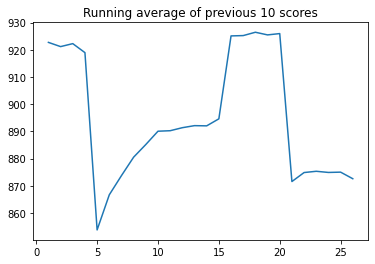

... saving models...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


episode 27 score 914.9 avg score 895.7 avg ep_len 697.5
episode 28 score 926.5 avg score 895.6 avg ep_len 698.2
episode 29 score 932.2 avg score 896.1 avg ep_len 695.0
episode 30 score 922.2 avg score 895.5 avg ep_len 700.9
episode 31 score 908.8 avg score 896.3 avg ep_len 714.2
episode 32 score 912.5 avg score 895.2 avg ep_len 720.1
episode 33 score 923.4 avg score 895.0 avg ep_len 722.4
episode 34 score 941.5 avg score 895.9 avg ep_len 715.2
episode 35 score 924.9 avg score 895.3 avg ep_len 721.5
episode 36 score 928.1 avg score 895.2 avg ep_len 721.6
episode 37 score 927.8 avg score 895.0 avg ep_len 724.0
episode 38 score 921.1 avg score 894.6 avg ep_len 728.2
episode 39 score 900.7 avg score 893.8 avg ep_len 735.4
episode 40 score 937.0 avg score 894.2 avg ep_len 730.7
... saving models...
episode 41 score 932.0 avg score 924.0 avg ep_len 749.7
... saving models...
episode 42 score 933.9 avg score 924.3 avg ep_len 747.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode 43 score 682.9 avg score 911.5 avg ep_len 747.7
episode 44 score 925.7 avg score 911.6 avg ep_len 746.5
episode 45 score 904.0 avg score 910.5 avg ep_len 748.6
episode 46 score 926.4 avg score 911.3 avg ep_len 740.9
episode 47 score 925.6 avg score 911.9 avg ep_len 735.5
episode 48 score 907.1 avg score 910.9 avg ep_len 742.0
episode 49 score 937.5 avg score 911.2 avg ep_len 739.4
episode 50 score 923.2 avg score 911.2 avg ep_len 738.9
episode 51 score 931.4 avg score 912.3 avg ep_len 727.5


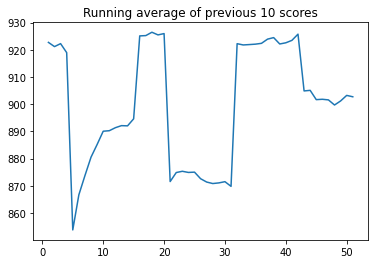

... saving models...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

episode 52 score 645.6 avg score 899.0 avg ep_len 714.0
episode 53 score 925.5 avg score 899.1 avg ep_len 713.0
episode 54 score 929.1 avg score 898.5 avg ep_len 719.1
episode 55 score 923.9 avg score 898.4 avg ep_len 719.6
episode 56 score 920.4 avg score 898.0 avg ep_len 723.5
episode 57 score 291.0 avg score 866.2 avg ep_len 700.1
episode 58 score 908.3 avg score 865.6 avg ep_len 706.5
episode 59 score 265.0 avg score 833.8 avg ep_len 674.0
episode 60 score 450.7 avg score 809.5 avg ep_len 660.5
episode 61 score 271.8 avg score 776.4 avg ep_len 638.6
episode 62 score 253.0 avg score 742.4 avg ep_len 616.8
episode 63 score 81.3 avg score 712.3 avg ep_len 592.8
episode 64 score 82.7 avg score 670.2 avg ep_len 562.1
episode 65 score 78.8 avg score 628.9 avg ep_len 528.5
episode 66 score 86.2 avg score 586.9 avg ep_len 498.3
episode 67 score 94.0 avg score 545.3 avg ep_len 467.6
episode 68 score 162.3 avg score 508.1 avg ep_len 433.1
episode 69 score 82.1 avg score 465.3 avg ep_len 408.

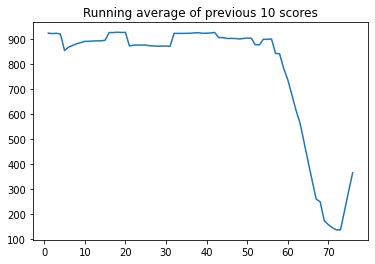

... saving models...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different length

episode 77 score 84.5 avg score 324.4 avg ep_len 306.1
episode 78 score 914.1 avg score 324.7 avg ep_len 298.1
episode 79 score 927.1 avg score 357.8 avg ep_len 322.1
episode 80 score 930.2 avg score 381.7 avg ep_len 339.0
episode 81 score 937.2 avg score 415.0 avg ep_len 358.2
episode 82 score 926.6 avg score 448.7 avg ep_len 383.7
episode 83 score 931.5 avg score 491.2 avg ep_len 411.3
episode 84 score 925.0 avg score 533.3 avg ep_len 442.2
episode 85 score 930.0 avg score 575.9 avg ep_len 471.1
episode 86 score 930.7 avg score 618.1 avg ep_len 499.1
episode 87 score 924.6 avg score 659.6 avg ep_len 530.4
episode 88 score 938.1 avg score 698.4 avg ep_len 552.5
episode 89 score 938.0 avg score 741.2 avg ep_len 577.2
episode 90 score 328.0 avg score 753.0 avg ep_len 584.0
episode 91 score 912.5 avg score 782.8 avg ep_len 603.5
episode 92 score 928.4 avg score 820.6 avg ep_len 628.5
episode 93 score 928.4 avg score 854.2 avg ep_len 652.1
episode 94 score 927.2 avg score 854.5 avg ep_len

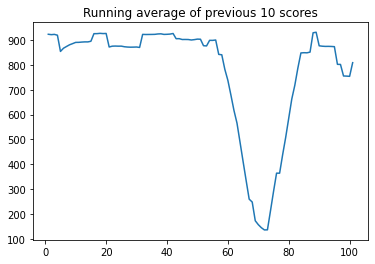

... saving models...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


episode 102 score 922.2 avg score 833.1 avg ep_len 642.0
episode 103 score 931.1 avg score 833.1 avg ep_len 642.2


KeyboardInterrupt: ignored

In [ ]:
train(lr=0.000005,n_games=500,gamma=0.94,action_space="both",steer_model="PPO_steer_final_860_smooth.pth",thrust_model="PPO_thrust_checkpoint.pth",steer_policy="deterministic",thrust_policy="stochastic")

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()
#simulate(steer_model = "PPO_steer_final_860_smooth.pth", thrust_model = "PPO_thrust_final.pth", steer_policy = "deterministic",thrust_policy="deterministic",render=True)
test_rews, test_ep_lens = official_test(steer_model = "PPO_steer_final_860_smooth.pth", thrust_model = "PPO_thrust_checkpoint(21).pth", steer_policy = "deterministic",thrust_policy="deterministic")
save_list(test_rews,filename="test_rews_det")
save_list(test_ep_lens,filename="test_ep_lens_det")

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


... loading models ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:247: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


score 931.1999999999904 ep_len 688
Test 0
rew = 931.1999999999904 ep_len = 688
av rew = 931.1999999999904 ep_len = 688 

score 918.7999999999894 ep_len 812
Test 1
rew = 918.7999999999894 ep_len = 812
av rew = 924.9999999999899 ep_len = 750 

score 926.3999999999835 ep_len 736
Test 2
rew = 926.3999999999835 ep_len = 736
av rew = 925.4666666666544 ep_len = 745.3333333333334 

score 930.0999999999884 ep_len 699
Test 3
rew = 930.0999999999884 ep_len = 699
av rew = 926.624999999988 ep_len = 733.75 

score 927.1999999999874 ep_len 728
Test 4
rew = 927.1999999999874 ep_len = 728
av rew = 926.7399999999878 ep_len = 732.6 

score 935.3999999999924 ep_len 646
Test 5
rew = 935.3999999999924 ep_len = 646
av rew = 928.1833333333219 ep_len = 718.1666666666666 

score 928.7999999999845 ep_len 712
Test 6
rew = 928.7999999999845 ep_len = 712
av rew = 928.2714285714165 ep_len = 717.2857142857143 

score 939.4999999999885 ep_len 605
Test 7
rew = 939.4999999999885 ep_len = 605
av rew = 929.674999999988 ep

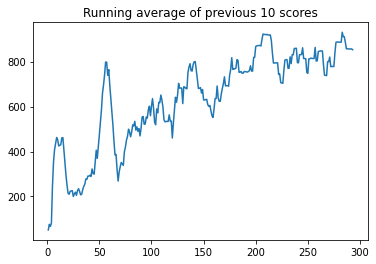

In [ ]:
l = load_list("reward_hist.data")
plot_learning_curve(l)